#### **CARTPOLE DQN KERAS (Minimal) V1**

This is a naive version of the CARTPOLE DQN algorithm <br>
This program works it has been serialized, but it is plain, no sophistications <br>


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import random
import gymnasium as gym
import time
import numpy as np
from collections import deque
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Use mixed-precision training for faster computations on supported GPUs
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Enable XLA (Accelerated Linear Algebra) optimization
tf.config.optimizer.set_jit(True)

Num GPUs Available:  1


I0000 00:00:1733850788.208409 3767381 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733850788.226411 3767381 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733850788.226452 3767381 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


#### **Hyperparameters**

In [2]:

EPISODES = 300

replay_buffer = deque(maxlen=2000)
gamma = 0.95    # discount rate
epsilon = 1.0  # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.001
batch_size = 64
solved_threshold = 195

verb = 0   # to see traces

In [3]:
# Environment setup
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

#### **Neural Network**

In [4]:
def build_model_old(state_size,action_size):
    model = Sequential()
    model.add(Dense(24, input_dim=state_size, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(loss='mse',optimizer=Adam(learning_rate=learning_rate))
    model.summary()
    return model

In [5]:
def build_model(state_size, action_size):
    inputs = Input(shape=(state_size,), name="state_input")
    x = Dense(24, activation='relu', name="dense_1")(inputs)
    x = Dense(24, activation='relu', name="dense_2")(x)
    outputs = Dense(action_size, activation='linear', name="output_layer")(x)
    
    model = Model(inputs=inputs, outputs=outputs, name="Q_Network")
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    model.summary()
    return model

#### **Support Functions**

In [6]:

def store(state, action, reward, next_state, done):             # memorize
    replay_buffer.append((state, action, reward, next_state, done))

def select_action_greedy(state, DQN):                                      # act
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    act_values = DQN.predict(state, verbose=verb)
    return np.argmax(act_values[0])  # returns action selected with greedy strategy

# Sample experiences from the replay buffer
def sample_experiences(batch_size):
    indices = np.random.choice(len(replay_buffer), batch_size, replace=False)
    batch = [replay_buffer[i] for i in indices]
    states, actions, rewards, next_states, dones = zip(*batch)
    return (
        np.vstack(states),
        np.array(actions),
        np.array(rewards),
        np.vstack(next_states),
        np.array(dones, dtype=np.float32)
    )

    
def experience_replay(batch_size, model, epsilon):
    if len(replay_buffer) < batch_size:
        return
    minibatch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = sample_experiences(batch_size)

    # Predict Q-values for current and next states using vectorized operations
    target_qs = model.predict(states, verbose=0)
    next_qs = model.predict(next_states, verbose=0)

    # Update target Q-values using standard DQN logic
    for i in range(batch_size):
        if dones[i]:
            target_qs[i, actions[i]] = rewards[i]
        else:
            target_qs[i, actions[i]] = rewards[i] + gamma * np.max(next_qs[i])

    # Train the model on the Q-values
    model.fit(states, target_qs, epochs=1, verbose=0)
    if epsilon > epsilon_min:
            epsilon *= epsilon_decay
    return epsilon

def load(name, DQN):
    DQN.load_weights(name)

def save(name, DQN):
    DQN.save_weights(name)

In [7]:
rewards_per_episode= []
DQN = build_model(state_size, action_size)

env = gym.make('CartPole-v1')

    # agent.load("./save/cartpole-dqn.h5")
done = False
rolling_avg = 0
rolling_avg_rewards = []

for e in range(EPISODES):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    for step in range(500):
            
        action = select_action_greedy(state, DQN)
        next_state, reward, done, truncated , _ = env.step(action)
        if truncated:
            done = True
        reward = reward if not done else -10                      
        next_state = np.reshape(next_state, [1, state_size])
        store(state, action, reward, next_state, done)
        state = next_state
        total_reward = total_reward + reward
        if done:
            rewards_per_episode.append(total_reward)
            rolling_avg = np.mean(rewards_per_episode[-10:])
            rolling_avg_rewards.append(rolling_avg)
            print(f"Episode: {e+1:3}/{EPISODES:3}, Reward: {total_reward:+6.2f}, "
                  f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:4.2f}, Steps: {step:3}, Terminated: {done} ")
            break
            
        if len(replay_buffer) > batch_size:
            epsilon = experience_replay(batch_size, DQN, epsilon)
            
    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {e+1} episodes!")
#            model.save("lunarlander_ddqn_model1.keras")
        break

I0000 00:00:1733850788.268893 3767381 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733850788.268954 3767381 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733850788.268970 3767381 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733850789.060248 3767381 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733850789.060293 3767381 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "Q_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ state_input (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770 (3.01 KB)

 Trainable params: 770 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

Episode: 1/300, Reward: +10.00, Epsilon: 1.00, Rolling Avg: 10.00, Steps:  20, Terminated: True 
Episode: 2/300, Reward:  +8.00, Epsilon: 1.00, Rolling Avg: 9.00, Steps:  18, Terminated: True 
Episode: 3/300, Reward:  +2.00, Epsilon: 1.00, Rolling Avg: 6.67, Steps:  12, Terminated: True 


I0000 00:00:1733850789.756937 3767475 service.cc:146] XLA service 0x7f004c003b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733850789.756994 3767475 service.cc:154]   StreamExecutor device (0): NVIDIA T600 Laptop GPU, Compute Capability 7.5
I0000 00:00:1733850791.042021 3767475 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode: 4/300, Reward:  +5.00, Epsilon: 0.98, Rolling Avg: 6.25, Steps:  15, Terminated: True 
Episode: 5/300, Reward: +22.00, Epsilon: 0.83, Rolling Avg: 9.40, Steps:  32, Terminated: True 
Episode: 6/300, Reward: +33.00, Epsilon: 0.67, Rolling Avg: 13.33, Steps:  43, Terminated: True 
Episode: 7/300, Reward:  +8.00, Epsilon: 0.61, Rolling Avg: 12.57, Steps:  18, Terminated: True 
Episode: 8/300, Reward: +40.00, Epsilon: 0.48, Rolling Avg: 16.00, Steps:  50, Terminated: True 
Episode: 9/300, Reward:  -1.00, Epsilon: 0.46, Rolling Avg: 14.11, Steps:   9, Terminated: True 
Episode: 10/300, Reward:  -1.00, Epsilon: 0.44, Rolling Avg: 12.60, Steps:   9, Terminated: True 
Episode: 11/300, Reward:  +0.00, Epsilon: 0.42, Rolling Avg: 11.60, Steps:  10, Terminated: True 
Episode: 12/300, Reward:  +8.00, Epsilon: 0.38, Rolling Avg: 11.60, Steps:  18, Terminated: True 
Episode: 13/300, Reward: +36.00, Epsilon: 0.30, Rolling Avg: 15.00, Steps:  46, Terminated: True 
Episode: 14/300, Reward: +29

Episode: 87/300, Reward: +119.00, Epsilon: 0.01, Rolling Avg: 118.50, Steps: 129, Terminated: True 
Episode: 88/300, Reward: +119.00, Epsilon: 0.01, Rolling Avg: 119.10, Steps: 129, Terminated: True 
Episode: 89/300, Reward: +134.00, Epsilon: 0.01, Rolling Avg: 119.10, Steps: 144, Terminated: True 
Episode: 90/300, Reward: +121.00, Epsilon: 0.01, Rolling Avg: 119.40, Steps: 131, Terminated: True 
Episode: 91/300, Reward: +116.00, Epsilon: 0.01, Rolling Avg: 120.50, Steps: 126, Terminated: True 
Episode: 92/300, Reward: +118.00, Epsilon: 0.01, Rolling Avg: 120.00, Steps: 128, Terminated: True 
Episode: 93/300, Reward: +123.00, Epsilon: 0.01, Rolling Avg: 121.00, Steps: 133, Terminated: True 
Episode: 94/300, Reward: +115.00, Epsilon: 0.01, Rolling Avg: 120.80, Steps: 125, Terminated: True 
Episode: 95/300, Reward: +117.00, Epsilon: 0.01, Rolling Avg: 120.30, Steps: 127, Terminated: True 
Episode: 96/300, Reward: +115.00, Epsilon: 0.01, Rolling Avg: 119.70, Steps: 125, Terminated: True 


Episode: 169/300, Reward: +104.00, Epsilon: 0.01, Rolling Avg: 55.30, Steps: 114, Terminated: True 
Episode: 170/300, Reward: +141.00, Epsilon: 0.01, Rolling Avg: 68.70, Steps: 151, Terminated: True 
Episode: 171/300, Reward: +91.00, Epsilon: 0.01, Rolling Avg: 76.00, Steps: 101, Terminated: True 
Episode: 172/300, Reward: +158.00, Epsilon: 0.01, Rolling Avg: 89.90, Steps: 168, Terminated: True 
Episode: 173/300, Reward: +169.00, Epsilon: 0.01, Rolling Avg: 103.80, Steps: 179, Terminated: True 
Episode: 174/300, Reward: +114.00, Epsilon: 0.01, Rolling Avg: 110.80, Steps: 124, Terminated: True 
Episode: 175/300, Reward: +90.00, Epsilon: 0.01, Rolling Avg: 113.70, Steps: 100, Terminated: True 
Episode: 176/300, Reward: +123.00, Epsilon: 0.01, Rolling Avg: 117.20, Steps: 133, Terminated: True 
Episode: 177/300, Reward: +83.00, Epsilon: 0.01, Rolling Avg: 119.60, Steps:  93, Terminated: True 
Episode: 178/300, Reward: +195.00, Epsilon: 0.01, Rolling Avg: 126.80, Steps: 205, Terminated: Tru

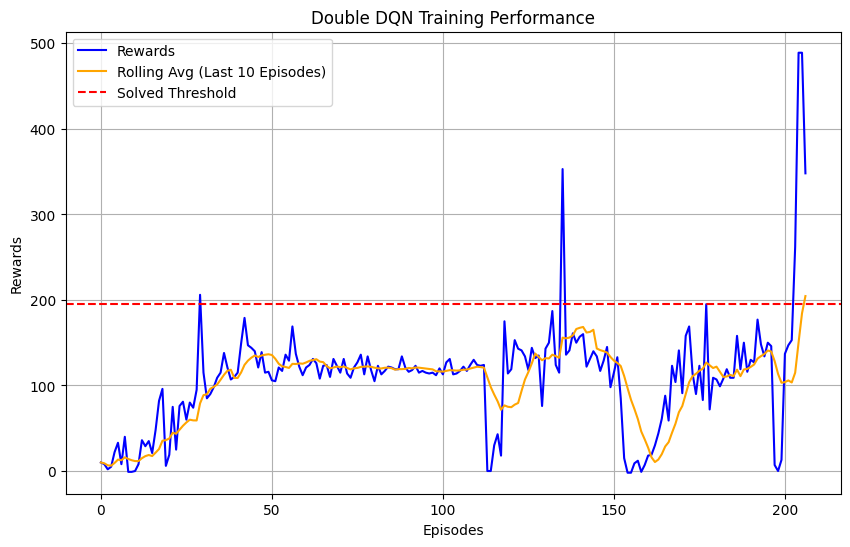

In [8]:
# Plot rewards with rolling average

plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last 10 Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('Double DQN Training Performance')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

#### **Simulation - Testing 10 episodes**

In [9]:
# Testing for 10 episodes
start_time = time.time()

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    while True:
        # Use the trained model for testing
        action_vals = DQN.predict(state, verbose=0)  # Predict action values
        action = np.argmax(action_vals[0])  # Choose the action with the highest Q-value

        next_state, reward, done, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1
        if done or truncated:
            print(f"Test Episode: {e_test + 1}/50, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")

Test Episode: 1/50, Reward: 500.00, Steps: 500
Test Episode: 2/50, Reward: 500.00, Steps: 500
Test Episode: 3/50, Reward: 487.00, Steps: 487
Test Episode: 4/50, Reward: 500.00, Steps: 500
Test Episode: 5/50, Reward: 451.00, Steps: 451
Test Episode: 6/50, Reward: 500.00, Steps: 500
Test Episode: 7/50, Reward: 500.00, Steps: 500
Test Episode: 8/50, Reward: 500.00, Steps: 500
Test Episode: 9/50, Reward: 500.00, Steps: 500
Test Episode: 10/50, Reward: 444.00, Steps: 444
Testing completed in 2.81 minutes


#### **Rendering 1 episode**

In [10]:
# Test the trained agent with video rendering
# This code is useful if you are using colab otherwise use render_mode='human'
env = gym.make(("CartPole-v1"), render_mode='rgb_array')  # Enable RGB rendering
frames = []  # Store frames for visualization

# Render a single test episode
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
tot_rewards = 0

while True:
    # Use the trained model for action
    action_vals = DQN.predict(state, verbose=0)  # Predict action values
    action = np.argmax(action_vals[0])           # Choose the action with the highest Q-value

    next_state, reward, done, truncated, _ = env.step(action)
    frames.append(env.render())                  # Save frame for rendering later
    next_state = np.reshape(next_state, [1, state_size])
    tot_rewards += reward
    state = next_state

    if done or truncated:
        print(f"Rendered Test Episode Reward: {tot_rewards:.2f}")
        break

env.close()

# Save the rendered episode as a GIF
def save_frames_as_gif(frames, path='./', filename='CARTPOLE_DQN.gif'):
    images = [Image.fromarray(frame) for frame in frames]
    gif_path = os.path.join(path, filename)
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=50, loop=0)
    print(f"Saved GIF to: {gif_path}")

save_frames_as_gif(frames, filename='CARTPOLE_DQN.gif')


Rendered Test Episode Reward: 500.00
Saved GIF to: ./CARTPOLE_DQN.gif


In [11]:
import session_info
session_info.show(html=False)

-----
PIL                 11.0.0
gymnasium           1.0.0
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
session_info        1.0.0
tensorflow          2.17.1
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Nov  6 2024, 18:32:19) [GCC 13.2.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2024-12-10 19:18
